<a target="_blank" href="https://colab.research.google.com/github/eeg2025/startkit/blob/main/challenge_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [18]:
# Save Model as .pt File
import os
from datetime import datetime

def save_model_as_pt(model, save_dir="models", filename=None):
    """
    Save EEGConformer model as .pt file (PyTorch format)
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"eegconformer_challenge1_{timestamp}.pt"
    
    model_path = os.path.join(save_dir, filename)
    
    # Save only the model state dict (standard .pt format)
    torch.save(model.state_dict(), model_path)
    
    print(f"✅ Model saved as .pt file: {model_path}")
    print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   File size: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")
    
    return model_path

def load_model_from_pt(model_path, device):
    """
    Load EEGConformer model from .pt file
    """
    # Model configuration (must match training configuration)
    model_config = {
        'n_chans': 129,
        'n_outputs': 1,
        'n_times': 200,
        'sfreq': 100,
        'n_filters_time': 40,
        'filter_time_length': 25,
        'pool_time_length': 75,
        'pool_time_stride': 15,
        'att_depth': 6,
        'att_heads': 10,
        'drop_prob': 0.5,
        'att_drop_prob': 0.5,
        'final_fc_length': 'auto',
        'return_features': False,
        'activation': torch.nn.ELU,
        'activation_transfor': torch.nn.GELU,
    }
    
    # Create model with same configuration
    model = EEGConformer(**model_config)
    
    # Load state dict
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set to evaluation mode
    
    print(f"✅ Model loaded from .pt file: {model_path}")
    print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    return model

# Example usage:
# Save model after training:
# model_path = save_model_as_pt(model_conformer, filename="my_eegconformer.pt")

# Load model for inference:
# loaded_model = load_model_from_pt(model_path, device)

print("💾 Model Saving/Loading Ready!")
print("Use save_model_as_pt() to save as .pt file")
print("Use load_model_from_pt() to load from .pt file")


💾 Model Saving/Loading Ready!
Use save_model_as_pt() to save as .pt file
Use load_model_from_pt() to load from .pt file


In [19]:
# Example: Save and Load Model
# This cell shows how to save your trained model as a .pt file

# After training your model, save it:
# model_path = save_model_as_pt(
#     model=model_conformer,
#     save_dir="models",
#     filename="eegconformer_final.pt"
# )

# To load the model later for inference:
# loaded_model = load_model_from_pt("models/eegconformer_final.pt", device)

# For submission purposes, you might want to save with a specific name:
# submission_path = save_model_as_pt(
#     model=model_conformer,
#     save_dir="submission_1",
#     filename="model_weights_challenge_1.pt"
# )

print("📝 Example Usage:")
print("1. Train your model")
print("2. Save with: save_model_as_pt(model_conformer, filename='my_model.pt')")
print("3. Load with: loaded_model = load_model_from_pt('my_model.pt', device)")
print("4. Use loaded_model for inference")

# Check if you have any existing .pt files
import glob
existing_models = glob.glob("*.pt") + glob.glob("models/*.pt") + glob.glob("submission_1/*.pt")
if existing_models:
    print(f"\n📁 Found existing .pt files:")
    for model_file in existing_models:
        size_mb = os.path.getsize(model_file) / 1024 / 1024
        print(f"   - {model_file} ({size_mb:.2f} MB)")
else:
    print("\n📁 No existing .pt files found")


📝 Example Usage:
1. Train your model
2. Save with: save_model_as_pt(model_conformer, filename='my_model.pt')
3. Load with: loaded_model = load_model_from_pt('my_model.pt', device)
4. Use loaded_model for inference

📁 No existing .pt files found


In [20]:
# Identify whether a CUDA-enabled GPU is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

No GPU found. Training will be carried out on CPU, which might be slower.

If running on Google Colab, you can request a GPU runtime by clicking
`Runtime/Change runtime type` in the top bar menu, then selecting 'T4 GPU'
under 'Hardware accelerator'.


In [21]:
from typing import Optional
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler
# Define a method for training one epoch
def train_one_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    optimizer,
    scheduler: Optional[LRScheduler],
    epoch: int,
    device,
    print_batch_stats: bool = True,
):
    model.train()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_samples = 0

    progress_bar = tqdm(
        enumerate(dataloader), total=len(dataloader), disable=not print_batch_stats
    )

    for batch_idx, batch in progress_bar:
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()

        optimizer.zero_grad(set_to_none=True)
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Flatten to 1D for regression metrics and accumulate squared error
        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            progress_bar.set_description(
                f"Epoch {epoch}, Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}, RMSE: {running_rmse:.6f}"
            )

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
    return avg_loss, rmse


For the challenge, we will need two significant dependencies: `braindecode` and `eegdash`. The libraries will install PyTorch, Pytorch Audio, Scikit-learn, MNE, MNE-BIDS, and many other packages necessary for the many functions.

In [22]:
from pathlib import Path

data_dir = Path("data")
available_releases = []

if data_dir.exists():
    for item in data_dir.iterdir():
        if item.is_dir() and item.name.startswith("release_"):
            release_num = item.name.split("_")[1]
            available_releases.append(int(release_num))

available_releases.sort()
print(f"Available releases: {available_releases}")

# Use release 5 (like original) or choose a different one
RELEASE_ID = 5  # Change this to use a different release
RELEASE_DIR = Path(f"data/release_{RELEASE_ID}")

if not RELEASE_DIR.exists():
    # print(f"❌ Release {RELEASE_ID} folder not found: {RELEASE_DIR}")
    print(f"Available releases: {available_releases}")
    # Use the first available release if R5 doesn't exist
    if available_releases:
        RELEASE_ID = available_releases[0]
        RELEASE_DIR = Path(f"data/release_{RELEASE_ID}")
        print(f"🔄 Using Release {RELEASE_ID} instead")
    else:
        raise FileNotFoundError("No release folders found in data/")

print(f"📁 Loading data from: {RELEASE_DIR.resolve()}")

from eegdash.dataset import EEGChallengeDataset

# Load from the specific release folder
dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release=f"R{RELEASE_ID}", cache_dir=RELEASE_DIR,
                                  mini=False)

print(f"Loaded dataset with {len(dataset_ccd.datasets)} recordings from Release R{RELEASE_ID}")

# Helper function to load different releases for transfer learning
def load_release_data(release_id, task="contrastChangeDetection", mini=False):
    """
    Load data from a specific release folder
    
    Args:
        release_id (int): Release number (1-11)
        task (str): Task name
        mini (bool): Whether to use mini dataset
    
    Returns:
        EEGChallengeDataset: Loaded dataset
    """
    release_dir = Path(f"data/release_{release_id}")
    
    if not release_dir.exists():
        raise FileNotFoundError(f"Release {release_id} folder not found: {release_dir}")
    
    print(f"Loading Release R{release_id} from: {release_dir.resolve()}")
    
    dataset = EEGChallengeDataset(
        task=task,
        release=f"R{release_id}",
        cache_dir=release_dir,
        mini=mini
    )
    
    print(f"Loaded {len(dataset.datasets)} recordings from Release R{release_id}")
    return dataset

# Example usage for transfer learning:
# source_data = load_release_data(1)  # Load release 1 for pre-training
# target_data = load_release_data(5)  # Load release 5 for target task


Available releases: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
📁 Loading data from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_5


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded dataset with 745 recordings from Release R5


In [23]:
# TRANSFER LEARNING SETUP: Load multiple releases for pre-training and target tasks
print("🔄 Setting up Transfer Learning with Multiple Releases")
print("="*60)

# Option 1: Load source data for pre-training (e.g., releases 1-3)
source_releases = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11]  # Releases to use for pre-training
source_datasets = []

print(f"📚 Loading source releases for pre-training: {source_releases}")
for release_id in source_releases:
    try:
        dataset = load_release_data(release_id, mini=False)
        source_datasets.append(dataset)
        print(f"✅ Added Release R{release_id}: {len(dataset.datasets)} recordings")
    except Exception as e:
        print(f"❌ Failed to load Release R{release_id}: {e}")

# Option 2: Load target data (e.g., release 5)
target_release = 5
print(f"\n🎯 Loading target release: R{target_release}")
try:
    target_dataset = load_release_data(target_release, mini=False)
    print(f"✅ Target dataset ready: {len(target_dataset.datasets)} recordings")
except Exception as e:
    print(f"❌ Failed to load target release: {e}")
    # Use the main dataset as fallback
    target_dataset = dataset_ccd
    print(f"🔄 Using main dataset as target: {len(target_dataset.datasets)} recordings")

# Summary
total_source_recordings = sum(len(dataset.datasets) for dataset in source_datasets)
print(f"\n📊 Transfer Learning Setup Summary:")
print(f"Source releases: {len(source_datasets)} releases, {total_source_recordings} recordings")
print(f"Target release: R{target_release}, {len(target_dataset.datasets)} recordings")
print(f"You can now use source data for pre-training and target data for fine-tuning!")


🔄 Setting up Transfer Learning with Multiple Releases
📚 Loading source releases for pre-training: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11]
Loading Release R1 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_1


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 293 recordings from Release R1
✅ Added Release R1: 293 recordings
Loading Release R2 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_2


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 301 recordings from Release R2
✅ Added Release R2: 301 recordings
Loading Release R3 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_3


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 388 recordings from Release R3
✅ Added Release R3: 388 recordings
Loading Release R4 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_4


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 756 recordings from Release R4
✅ Added Release R4: 756 recordings
Loading Release R6 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_6


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 232 recordings from Release R6
✅ Added Release R6: 232 recordings
Loading Release R7 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_7


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 529 recordings from Release R7
✅ Added Release R7: 529 recordings
Loading Release R8 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_8


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 512 recordings from Release R8
✅ Added Release R8: 512 recordings
Loading Release R9 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_9


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 655 recordings from Release R9
✅ Added Release R9: 655 recordings
Loading Release R10 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_10


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 212 recordings from Release R10
✅ Added Release R10: 212 recordings
Loading Release R11 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_11


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 767 recordings from Release R11
✅ Added Release R11: 767 recordings

🎯 Loading target release: R5
Loading Release R5 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_5


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 745 recordings from Release R5
✅ Target dataset ready: 745 recordings

📊 Transfer Learning Setup Summary:
Source releases: 10 releases, 4645 recordings
Target release: R5, 745 recordings
You can now use source data for pre-training and target data for fine-tuning!


In [24]:
# TEST DATA LOADING: Verify everything works with your folder structure
print("Testing Data Loading")
print("="*40)

# Test the main dataset
print(f"Main dataset (R{RELEASE_ID}):")
print(f"Location: {RELEASE_DIR.resolve()}")
print(f"Recordings: {len(dataset_ccd.datasets)}")

if len(dataset_ccd.datasets) > 0:
    # Show info about first recording
    raw = dataset_ccd.datasets[0].raw
    print(f"   🔬 First recording:")
    print(f"      - Channels: {len(raw.ch_names)}")
    print(f"      - Duration: {raw.times[-1]:.1f}s")
    print(f"      - Sampling rate: {raw.info['sfreq']} Hz")
    print(f"      - Channel names: {raw.ch_names[:5]}...")  # First 5 channels

# Test loading a different release
print(f"\n🔄 Testing loading different release...")
try:
    test_release = 1 if RELEASE_ID != 1 else 2  # Test with a different release
    test_dataset = load_release_data(test_release, mini=False)
    print(f"✅ Successfully loaded Release R{test_release}: {len(test_dataset.datasets)} recordings")
except Exception as e:
    print(f"❌ Failed to load test release: {e}")

print(f"\n🎉 Data loading test complete!")
print(f"💡 Your notebook is now ready to work with your downloaded data structure!")


Testing Data Loading
Main dataset (R5):
Location: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_5
Recordings: 745
   🔬 First recording:
      - Channels: 129
      - Duration: 197.0s
      - Sampling rate: 100.0 Hz
      - Channel names: ['E1', 'E2', 'E3', 'E4', 'E5']...

🔄 Testing loading different release...
Loading Release R1 from: /Users/carinaxguo/ESE 5380/eeg_challenge/data/release_1


/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Loaded 293 recordings from Release R1
✅ Successfully loaded Release R1: 293 recordings

🎉 Data loading test complete!
💡 Your notebook is now ready to work with your downloaded data structure!


In [25]:
#@title ▶️ Install additional required packages for colab
!pip install braindecode
!pip install eegdash


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [26]:
# from pathlib import Path

# DATA_DIR = Path("data")
# DATA_DIR.mkdir(parents=True, exist_ok=True)

# from eegdash.dataset import EEGChallengeDataset

# dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
#                                   release="R5", cache_dir=DATA_DIR,
#                                   mini=True)


In [27]:
from joblib import Parallel, delayed

raws = Parallel(n_jobs=-1)(
    delayed(lambda d: d.raw)(d) for d in dataset_ccd.datasets
)

In [28]:
#@title ▶️ Run this first to get all the utils functions for the epoching
from braindecode.datasets import BaseConcatDataset


In [29]:
lr = 0.002
weight_decay = 0.001
n_epochs = 25
early_stopping_patience = 8

In [30]:
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

EPOCH_LEN_S = 2.0
SFREQ = 100 # by definition here

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: 

In [31]:
# for each windows, we can extract the metainformation using:

meta_information = single_windows.get_metadata()

In [32]:
meta_information.head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,2241,2441,1.486,1.486,4.484,21.906,23.392,0,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution
1,0,3284,3484,1.562,1.562,4.57,32.34,33.902,1,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution
2,0,4322,4522,1.51,1.51,5.606,42.724,44.234,1,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution
3,0,5360,5560,0.97,0.97,3.972,53.096,54.066,0,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution
4,0,5714,5914,1.172,1.172,3.07,56.644,57.816,1,right_buttonPress,...,available,available,available,available,available,available,available,available,unavailable,caution


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

valid_frac = 0.1
test_frac = 0.1
seed = 2025

subjects = meta_information["subject"].unique()
sub_rm = ["NDARWV769JM7", "NDARME789TD2", "NDARUA442ZVF", "NDARJP304NK1",
          "NDARTY128YLU", "NDARDW550GU6", "NDARLD243KRE", "NDARUJ292JXV", "NDARBA381JGH"]
subjects = [s for s in subjects if s not in sub_rm]

train_subj, valid_test_subject = train_test_split(
    subjects, test_size=(valid_frac + test_frac), random_state=check_random_state(seed), shuffle=True
)

valid_subj, test_subj = train_test_split(
    valid_test_subject, test_size=test_frac, random_state=check_random_state(seed + 1), shuffle=True
)
# sanity check
assert (set(valid_subj) | set(test_subj) | set(train_subj)) == set(subjects)

In [34]:
# and finally using braindecode split function, we can do:
subject_split = single_windows.split("subject")

train_set = []
valid_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])
    elif s in valid_subj:
        valid_set.append(subject_split[s])
    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")
print(f"Test:\t{len(test_set)}")

Number of examples in each split in the minirelease
Train:	12100
Valid:	2714
Test:	330


In [35]:
# Create datasets and dataloaders
from torch.utils.data import DataLoader

batch_size = 128
num_workers = 1 # We are using a single worker, but you can increase this for faster data loading

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Building the deep learning model

For neural network models, **to start**, we suggest using [braindecode models](https://braindecode.org/1.2/models/models_table.html) zoo. We have implemented several different models for decoding the brain timeseries.

Your team's responsibility is to develop a PyTorch module that receives the three-dimensional (`batch`, `n_chans`, `n_times`) input and outputs the contrastive response time.

In [36]:
from braindecode.models.util import models_dict

names = sorted(models_dict)
w = max(len(n) for n in names)

for i in range(0, len(names), 3):
    row = names[i:i+3]
    print("  ".join(f"{n:<{w}}" for n in row))

ATCNet                  AttentionBaseNet        AttnSleep             
BDTCN                   BIOT                    CTNet                 
ContraWR                Deep4Net                DeepSleepNet          
EEGConformer            EEGITNet                EEGInceptionERP       
EEGInceptionMI          EEGMiner                EEGNeX                
EEGNet                  EEGSimpleConv           EEGTCNet              
FBCNet                  FBLightConvNet          FBMSNet               
IFNet                   Labram                  MSVTNet               
SCCNet                  SPARCNet                ShallowFBCSPNet       
SignalJEPA              SignalJEPA_Contextual   SignalJEPA_PostLocal  
SignalJEPA_PreLocal     SincShallowNet          SleepStagerBlanco2020 
SleepStagerChambon2018  SyncNet                 TIDNet                
TSception               USleep                


In [37]:
from braindecode.models import EEGConformer
model2 = EEGConformer(n_chans=129, # 129 channels
                n_outputs=1, # 1 output for regression
                n_times=200, #2 seconds
                sfreq=100,      # sample frequency 100 Hz
                )

print(model2)

Layer (type (var_name):depth-idx)                                      Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                            [1, 129, 200]             [1, 1]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                               [1, 1, 129, 200]          [1, 7, 40]                --                        --
│    └─Sequential (shallownet): 2-1                                    [1, 1, 129, 200]          [1, 40, 1, 7]             --                        --
│    │    └─Conv2d (0): 3-1                                            [1, 1, 129, 200]          [1, 40, 129, 176]         1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                            [1, 40, 129, 176]         [1, 40, 1, 176]           206,440                   [129, 1]
│    │    └─BatchNorm2d (2): 3-3                                   

/Users/carinaxguo/ESE 5380/eeg_challenge/.venv/lib/python3.11/site-packages/braindecode/models/eegconformer.py:227: UserWarning: This model has only been tested on no more than 64 channels. no guarantee to work with more channels.
  warnings.warn(


In [24]:
# optimizer = torch.optim.AdamW(model2.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs - 1)
# loss_fn = torch.nn.MSELoss()

# patience = 5
# min_delta = 1e-4
# best_rmse = float("inf")
# epochs_no_improve = 0
# best_state, best_epoch = None, None

# for epoch in range(1, n_epochs + 1):
#     print(f"Epoch {epoch}/{n_epochs}: ", end="")

#     train_loss, train_rmse = train_one_epoch(
#         train_loader, model2, loss_fn, optimizer, scheduler, epoch, device
#     )
#     val_loss, val_rmse = valid_model(test_loader, model2, loss_fn, device)

#     print(
#         f"Train RMSE: {train_rmse:.6f}, "
#         f"Average Train Loss: {train_loss:.6f}, "
#         f"Val RMSE: {val_rmse:.6f}, "
#         f"Average Val Loss: {val_loss:.6f}"
#     )

#     if val_rmse < best_rmse - min_delta:
#         best_rmse = val_rmse
#         best_state = copy.deepcopy(model2.state_dict())
#         best_epoch = epoch
#         epochs_no_improve = 0
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve >= patience:
#             print(f"Early stopping at epoch {epoch}. Best Val RMSE: {best_rmse:.6f} (epoch {best_epoch})")
#             break

# if best_state is not None:
#     model2.load_state_dict(best_state)

In [14]:
# EEGConformer training with L1/L2 (ridge/lasso) sweep and plots
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from braindecode.models import EEGConformer

# Assumes these exist from earlier cells:
# - device
# - train_loader, valid_loader (val == releases 5 & 6 per your split)
# - train_one_epoch, valid_model

def train_conformer_with_regularization(
    model_type: str,
    lam: float,
    *,
    n_epochs: int = 8,
    lr: float = 1e-3,
    print_batch_stats: bool = False,
):
    """
    model_type: 'ridge' -> L2 via optimizer weight_decay
                'lasso' -> L1 penalty added to loss
    lam: regularization strength
    Returns (final_train_rmse, final_val_rmse) computed without reg terms.
    """
    assert model_type in ("ridge", "lasso")

    model = EEGConformer(n_chans=129, n_outputs=1, n_times=200, sfreq=100).to(device)
    loss_fn = MSELoss()

    if model_type == "ridge":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=lam)
        add_l1 = False
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
        add_l1 = True

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs - 1)

    best_val = float("inf")
    best_state = None

    for epoch in range(1, n_epochs + 1):
        # One epoch train; for L1 add |w| term
        model.train()
        for X, y, *_ in train_loader:
            X = X.to(device).float()
            y = y.to(device).float()
            optimizer.zero_grad(set_to_none=True)
            preds = model(X)
            loss = loss_fn(preds, y)
            if add_l1:
                l1 = 0.0
                for p in model.parameters():
                    if p.requires_grad:
                        l1 = l1 + p.abs().sum()
                loss = loss + lam * l1
            loss.backward()
            optimizer.step()
        scheduler.step()

        # Validation (plain MSE)
        val_loss, _ = valid_model(valid_loader, model, loss_fn, device, print_batch_stats=print_batch_stats)
        if val_loss < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    # Final train/val RMSE (no reg term) - compute RMSE = sqrt(MSE)
    model.eval()
    with torch.no_grad():
        t_sum_sq_err, t_n = 0.0, 0
        for X, y, *_ in train_loader:
            X = X.to(device).float()
            y = y.to(device).float()
            pred = model(X)
            pred_flat = pred.view(-1)
            y_flat = y.view(-1)
            t_sum_sq_err += torch.sum((pred_flat - y_flat) ** 2).item()
            t_n += y_flat.numel()

        v_sum_sq_err, v_n = 0.0, 0
        for X, y, *_ in valid_loader:
            X = X.to(device).float()
            y = y.to(device).float()
            pred = model(X)
            pred_flat = pred.view(-1)
            y_flat = y.view(-1)
            v_sum_sq_err += torch.sum((pred_flat - y_flat) ** 2).item()
            v_n += y_flat.numel()

    train_rmse = (t_sum_sq_err / max(t_n, 1)) ** 0.5
    val_rmse = (v_sum_sq_err / max(v_n, 1)) ** 0.5
    return train_rmse, val_rmse


In [15]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Module
from tqdm import tqdm

@torch.no_grad()
def valid_model(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    device,
    print_batch_stats: bool = True,
):
    model.eval()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_batches = len(dataloader)
    n_samples = 0

    iterator = tqdm(
        enumerate(dataloader),
        total=n_batches,
        disable=not print_batch_stats
    )

    for batch_idx, batch in iterator:
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()
        # casting X to float32

        preds = model(X)
        batch_loss = loss_fn(preds, y).item()
        total_loss += batch_loss

        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            iterator.set_description(
                f"Val Batch {batch_idx + 1}/{n_batches}, "
                f"Loss: {batch_loss:.6f}, RMSE: {running_rmse:.6f}"
            )

    avg_loss = total_loss / n_batches if n_batches else float("nan")
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5

    print(f"Val RMSE: {rmse:.6f}, Val Loss: {avg_loss:.6f}\n")
    return avg_loss, rmse

Val RMSE: 0.470269, Val Loss: 0.220182

Val RMSE: 0.482575, Val Loss: 0.226910

Val RMSE: 0.441411, Val Loss: 0.192129

Val RMSE: 0.470648, Val Loss: 0.215491

Val RMSE: 0.430406, Val Loss: 0.182392

Val RMSE: 0.434999, Val Loss: 0.185106

Val RMSE: 0.421884, Val Loss: 0.174809

Val RMSE: 0.425345, Val Loss: 0.177471

Val RMSE: 0.527127, Val Loss: 0.270079

Val RMSE: 0.492292, Val Loss: 0.236521

Val RMSE: 0.420901, Val Loss: 0.175619

Val RMSE: 0.466875, Val Loss: 0.217605

Val RMSE: 0.442363, Val Loss: 0.193337

Val RMSE: 0.436715, Val Loss: 0.187802

Val RMSE: 0.426536, Val Loss: 0.178780

Val RMSE: 0.433878, Val Loss: 0.185151

Val RMSE: 0.415107, Val Loss: 0.170450

Val RMSE: 0.582689, Val Loss: 0.329771

Val RMSE: 0.447679, Val Loss: 0.198574

Val RMSE: 0.504952, Val Loss: 0.255880

Val RMSE: 0.854683, Val Loss: 0.716131

Val RMSE: 0.426474, Val Loss: 0.178736

Val RMSE: 0.426595, Val Loss: 0.179492

Val RMSE: 0.438784, Val Loss: 0.189732

Val RMSE: 0.437455, Val Loss: 0.191037



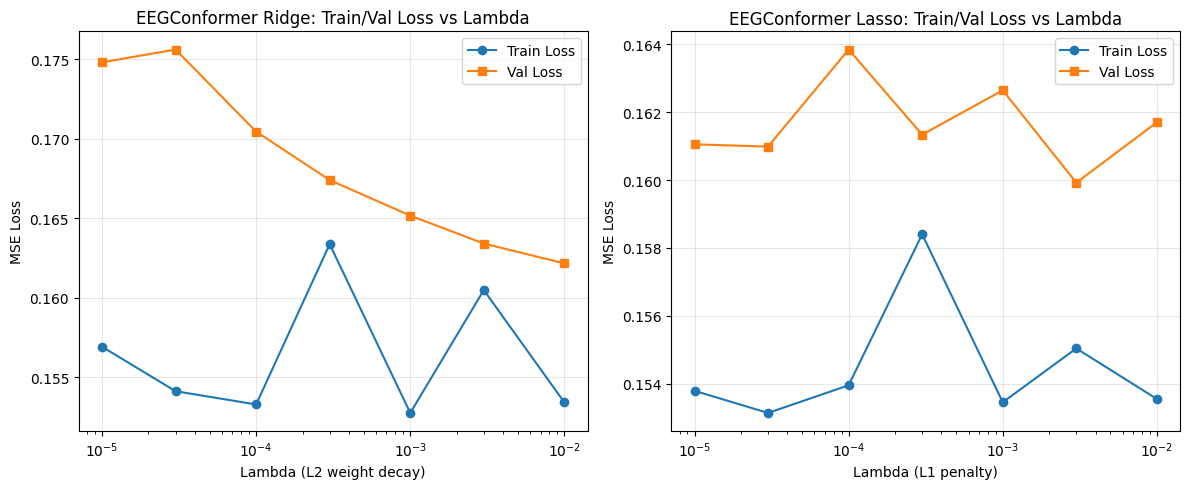

Ridge:
     1e-05: train=0.156917, val=0.174809
     3e-05: train=0.154119, val=0.175619
    0.0001: train=0.153284, val=0.170450
    0.0003: train=0.163372, val=0.167404
     0.001: train=0.152750, val=0.165167
     0.003: train=0.160481, val=0.163410
      0.01: train=0.153411, val=0.162159

Lasso:
     1e-05: train=0.153791, val=0.161053
     3e-05: train=0.153139, val=0.160984
    0.0001: train=0.153954, val=0.163846
    0.0003: train=0.158402, val=0.161337
     0.001: train=0.153454, val=0.162644
     0.003: train=0.155040, val=0.159922
      0.01: train=0.153551, val=0.161701


In [ ]:

# # Sweep lambdas and plot
# lambdas = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]

# # Ridge (L2)
# ridge_train, ridge_val = [], []
# for lam in lambdas:
#     tr, va = train_conformer_with_regularization("ridge", lam, n_epochs=8, lr=1e-3)
#     ridge_train.append(tr)
#     ridge_val.append(va)

# # Lasso (L1)
# lasso_train, lasso_val = [], []
# for lam in lambdas:
#     tr, va = train_conformer_with_regularization("lasso", lam, n_epochs=8, lr=1e-3)
#     lasso_train.append(tr)
#     lasso_val.append(va)

# # Plots: two graphs, each with train and val vs lambda
# plt.figure(figsize=(12, 5))

# # Ridge
# plt.subplot(1, 2, 1)
# plt.plot(lambdas, ridge_train, marker='o', label='Train Loss')
# plt.plot(lambdas, ridge_val, marker='s', label='Val Loss')
# plt.xscale('log')
# plt.xlabel('Lambda (L2 weight decay)')
# plt.ylabel('MSE Loss')
# plt.title('EEGConformer Ridge: Train/Val Loss vs Lambda')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Lasso
# plt.subplot(1, 2, 2)
# plt.plot(lambdas, lasso_train, marker='o', label='Train Loss')
# plt.plot(lambdas, lasso_val, marker='s', label='Val Loss')
# plt.xscale('log')
# plt.xlabel('Lambda (L1 penalty)')
# plt.ylabel('MSE Loss')
# plt.title('EEGConformer Lasso: Train/Val Loss vs Lambda')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print("Ridge:")
# for lam, tr, va in zip(lambdas, ridge_train, ridge_val):
#     print(f"  {lam:>8}: train={tr:.6f}, val={va:.6f}")
# print("\nLasso:")
# for lam, tr, va in zip(lambdas, lasso_train, lasso_val):
#     print(f"  {lam:>8}: train={tr:.6f}, val={va:.6f}")

In [ ]:
# torch.save(model2.state_dict(), "eegconformer_reg.pth")

In [52]:
# model_path = save_model_as_pt(
#     model=model2,
#     filename="eegconformer_final.pt"
# )

Val RMSE: 0.547506, Val Loss: 0.292469

Val RMSE: 0.570443, Val Loss: 0.324540

Val RMSE: 0.474929, Val Loss: 0.223046

Val RMSE: 0.452398, Val Loss: 0.200310

Val RMSE: 0.470865, Val Loss: 0.215890

Val RMSE: 0.450758, Val Loss: 0.198399

Val RMSE: 0.443146, Val Loss: 0.193460

Val RMSE: 0.439612, Val Loss: 0.190376

Val RMSE: 0.699666, Val Loss: 0.477469

Val RMSE: 0.608046, Val Loss: 0.370165

Val RMSE: 0.681922, Val Loss: 0.468033

Val RMSE: 0.453850, Val Loss: 0.205036

Val RMSE: 0.581927, Val Loss: 0.329036

Val RMSE: 0.450210, Val Loss: 0.199264

Val RMSE: 0.459430, Val Loss: 0.205799

Val RMSE: 0.452186, Val Loss: 0.201619

Val RMSE: 0.494370, Val Loss: 0.245670

Val RMSE: 0.447113, Val Loss: 0.197682

Val RMSE: 0.411016, Val Loss: 0.166153

Val RMSE: 0.411015, Val Loss: 0.166610

Val RMSE: 0.429894, Val Loss: 0.180368

Val RMSE: 0.428602, Val Loss: 0.179467

Val RMSE: 0.416592, Val Loss: 0.170981

Val RMSE: 0.416768, Val Loss: 0.171359

Val RMSE: 0.497073, Val Loss: 0.249338



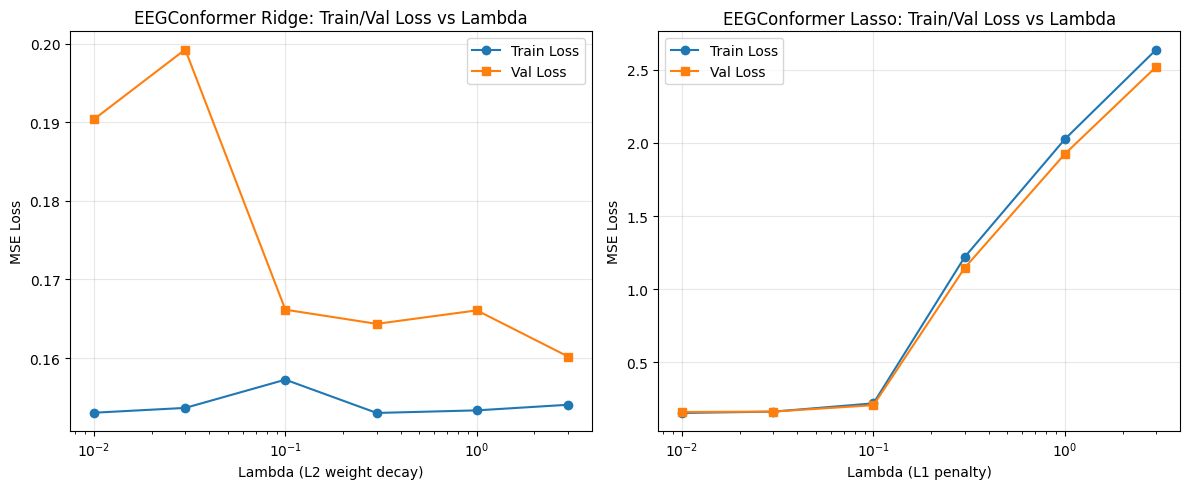

Ridge:
      0.01: train=0.153039, val=0.190376
      0.03: train=0.153652, val=0.199264
       0.1: train=0.157246, val=0.166153
       0.3: train=0.153010, val=0.164350
         1: train=0.153339, val=0.166064
         3: train=0.154054, val=0.160181

Lasso:
      0.01: train=0.153951, val=0.160272
      0.03: train=0.162887, val=0.163259
       0.1: train=0.219568, val=0.207122
       0.3: train=1.220800, val=1.146986
         1: train=2.026537, val=1.925188
         3: train=2.639152, val=2.521601


In [ ]:

# # Sweep lambdas and plot
# lambdas = [0.01, 0.03, 0.1, 0.3, 1, 3]

# # Ridge (L2)
# ridge_train, ridge_val = [], []
# for lam in lambdas:
#     tr, va = train_conformer_with_regularization("ridge", lam, n_epochs=8, lr=1e-3)
#     ridge_train.append(tr)
#     ridge_val.append(va)

# # Lasso (L1)
# lasso_train, lasso_val = [], []
# for lam in lambdas:
#     tr, va = train_conformer_with_regularization("lasso", lam, n_epochs=8, lr=1e-3)
#     lasso_train.append(tr)
#     lasso_val.append(va)

# # Plots: two graphs, each with train and val vs lambda
# plt.figure(figsize=(12, 5))

# # Ridge
# plt.subplot(1, 2, 1)
# plt.plot(lambdas, ridge_train, marker='o', label='Train Loss')
# plt.plot(lambdas, ridge_val, marker='s', label='Val Loss')
# plt.xscale('log')
# plt.xlabel('Lambda (L2 weight decay)')
# plt.ylabel('MSE Loss')
# plt.title('EEGConformer Ridge: Train/Val Loss vs Lambda')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Lasso
# plt.subplot(1, 2, 2)
# plt.plot(lambdas, lasso_train, marker='o', label='Train Loss')
# plt.plot(lambdas, lasso_val, marker='s', label='Val Loss')
# plt.xscale('log')
# plt.xlabel('Lambda (L1 penalty)')
# plt.ylabel('MSE Loss')
# plt.title('EEGConformer Lasso: Train/Val Loss vs Lambda')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print("Ridge:")
# for lam, tr, va in zip(lambdas, ridge_train, ridge_val):
#     print(f"  {lam:>8}: train={tr:.6f}, val={va:.6f}")
# print("\nLasso:")
# for lam, tr, va in zip(lambdas, lasso_train, lasso_val):
#     print(f"  {lam:>8}: train={tr:.6f}, val={va:.6f}")

In [ ]:

lambdas = [1e-3, 3e-3, 1e-2, 2e-2, 4e-2, 6e-2, 8e-2, 1e-1]

# Ridge (L2)
ridge_train, ridge_val = [], []
for lam in lambdas:
    tr, va = train_conformer_with_regularization("ridge", lam, n_epochs=25, lr=0.002)
    ridge_train.append(tr)
    ridge_val.append(va)

# Lasso (L1)
lasso_train, lasso_val = [], []
for lam in lambdas:
    tr, va = train_conformer_with_regularization("lasso", lam, n_epochs=25, lr=0.002)
    lasso_train.append(tr)
    lasso_val.append(va)

# Plots: two graphs, each with train and val vs lambda
plt.figure(figsize=(12, 5))

# Ridge
plt.subplot(1, 2, 1)
plt.plot(lambdas, ridge_train, marker='o', label='Train RMSE')
plt.plot(lambdas, ridge_val, marker='s', label='Val RMSE')
plt.xscale('log')
plt.xlabel('Lambda (L2 weight decay)')
plt.ylabel('RMSE')
plt.title('EEGConformer Ridge: Train/Val RMSE vs Lambda')
plt.legend()
plt.grid(True, alpha=0.3)

# Lasso
plt.subplot(1, 2, 2)
plt.plot(lambdas, lasso_train, marker='o', label='Train RMSE')
plt.plot(lambdas, lasso_val, marker='s', label='Val RMSE')
plt.xscale('log')
plt.xlabel('Lambda (L1 penalty)')
plt.ylabel('RMSE')
plt.title('EEGConformer Lasso: Train/Val RMSE vs Lambda')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Ridge:")
for lam, tr, va in zip(lambdas, ridge_train, ridge_val):
    print(f"  {lam:>8}: train={tr:.6f}, val={va:.6f}")
print("\nLasso:")
for lam, tr, va in zip(lambdas, lasso_train, lasso_val):
    print(f"  {lam:>8}: train={tr:.6f}, val={va:.6f}")

Val RMSE: 0.467904, Val Loss: 0.215970

Val RMSE: 0.717481, Val Loss: 0.518122

Val RMSE: 0.485450, Val Loss: 0.231842

Val RMSE: 0.509566, Val Loss: 0.258185

Val RMSE: 0.515905, Val Loss: 0.266462

Val RMSE: 0.441443, Val Loss: 0.194068

Val RMSE: 0.475540, Val Loss: 0.226597

Val RMSE: 0.444089, Val Loss: 0.192720

Val RMSE: 0.455635, Val Loss: 0.207095

Val RMSE: 0.424100, Val Loss: 0.177197

Val RMSE: 0.503419, Val Loss: 0.246323

Val RMSE: 0.420856, Val Loss: 0.174817

Val RMSE: 0.422259, Val Loss: 0.175976

Val RMSE: 0.423403, Val Loss: 0.178530

Val RMSE: 0.487774, Val Loss: 0.238988

Val RMSE: 0.454817, Val Loss: 0.206684

Val RMSE: 0.453302, Val Loss: 0.206069

Val RMSE: 0.421675, Val Loss: 0.175953

